# BoW Classification

## Group members

- Henrique Krausburg Correa
- xxx
- xxx

## Objective

Use [Colab notebook](https://colab.research.google.com/drive/1qhQ8b7F0iL4J2XFV_G_Ari9hfozZzjG4?usp=sharing) to solve the following question:

*Does n-grams (uni+bi or uni+bi+tri) improves classification?*

## Answer

No. The model accuracy drops as the n-grams tuple value increases.
Since increasing the n-gram value makes the number of token repeat themselves, this penalizes the TF-IDF model, which sets a higher score based on token uniqueness (the less a token shows up among documents, the higher its score).


In [61]:
# Install environment dependencies
%pip install unidecode nltk pandas numpy matplotlib seaborn scikit-learn yellowbrick setuptools

Note: you may need to restart the kernel to use updated packages.


In [62]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
nltk.download("punkt")
nltk.download("punkt_tab")
from unidecode import unidecode
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm, naive_bayes
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\br31293\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\br31293\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [63]:
# Download train and test data
!curl https://www.inf.ufrgs.br/~viviane/DS/B2W-Reviews01_binario5000_TRAIN.csv > B2W-Reviews01_binario5000_TRAIN.csv
!curl https://www.inf.ufrgs.br/~viviane/DS/B2W-Reviews01_binario_TEST.csv > B2W-Reviews01_binario_TEST.csv
df_train = pd.read_csv('B2W-Reviews01_binario5000_TRAIN.csv')
df_test = pd.read_csv('B2W-Reviews01_binario_TEST.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1657k  100 1657k    0     0  6395k      0 --:--:-- --:--:-- --:--:-- 6498k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  981k  100  981k    0     0  6378k      0 --:--:-- --:--:-- --:--:-- 6543k


In [64]:
# Preprocess the data
special_chars = "¨'!#$%&()*+,-./:;<=>?@[\]^_`{|}~"
stop_words = stopwords.words('portuguese')

stop_words.remove('não') # keep 'não' on stop words list

def preprocess(x):
    new_x = x.replace('"',' ')
    for c in special_chars:
        new_x = new_x.replace(c,' ')
    new_x = ' '.join([word for word in nltk.word_tokenize(new_x.lower(),language='portuguese') if word not in stop_words]) #removendo stop words
    new_x = re.sub(r'[^\w\s]', ' ', new_x) # Remove punctuation
    new_x = re.sub("http\S+", ' ',new_x) #  Remove links
    new_x = re.sub("@\w+", ' ',new_x) # Remove mentions
    new_x = re.sub('#\S+', ' ',new_x) # hashtags
    new_x = re.sub('[0-9]+', ' ',new_x) # remove numbers and words with numbers
    new_x = unidecode(new_x) # Remove accents
    new_x = re.sub("\s+", ' ',new_x) # Remove spaces
    new_x = new_x.strip()
    return new_x

# Pre-processing the text data
df_train['text_original'] = df_train['text']
df_train['text'] = df_train['text'].apply(preprocess)

df_test['text_original'] = df_test['text']
df_test['text'] = df_test['text'].apply(preprocess)

df_train = df_train.sample(n=len(df_train)).copy() # shuffle dataframe
df_train.reset_index(drop=True, inplace=True)

# Remove empty rows and NaN values
df_train = df_train[df_train['text']!='']
df_train = df_train[~df_train['text'].isna()]
df_train.reset_index(drop=True, inplace=True) # reindex dataframe

# Remove duplicates
dup = df_train[df_train.duplicated(subset=['text'])]
df_train = df_train.drop(dup.index)
df_train.reset_index(drop=True, inplace=True) # reindex dataframe

# Check the distribution of the labels
#df_train.groupby(['label_descr', 'label'])

<>:2: SyntaxWarning: invalid escape sequence '\]'
<>:13: SyntaxWarning: invalid escape sequence '\S'
<>:14: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\S'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\]'
<>:13: SyntaxWarning: invalid escape sequence '\S'
<>:14: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\S'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\br31293\AppData\Local\Temp\ipykernel_25824\1704443048.py:2: SyntaxWarning: invalid escape sequence '\]'
  special_chars = "¨'!#$%&()*+,-./:;<=>?@[\]^_`{|}~"
C:\Users\br31293\AppData\Local\Temp\ipykernel_25824\1704443048.py:13: SyntaxWarning: invalid escape sequence '\S'
  new_x = re.sub("http\S+", ' ',new_x) #  Remove links
C:\Users\br31293\AppData\Local\Temp\ipykernel_25824\1704443048.py:14: SyntaxWarning: invalid escape sequence '\w'
  new_x = re.sub("@\w+", ' ',new_x) # Remov

In [65]:
def printOutOfVocabularyWords (train, test):
  tokens_nltk = []
  for t in train.values:
    tokens_nltk.extend(nltk.word_tokenize(t, language='portuguese'))

  vocab_test = set(tokens_nltk)
  
  tokens_nltk = []
  for t in test.values:
    tokens_nltk.extend(nltk.word_tokenize(t, language='portuguese'))

  vocab_train = set(tokens_nltk)
  

  # oov has words that appear in the test but not in the train set
  oov = vocab_test.difference(vocab_train) 
  print('Número de palavras que estão no teste e não no treino (OOV):',len(oov))

# Print out of vocabulary words
printOutOfVocabularyWords(df_train['text'], df_test['text'])

Número de palavras que estão no teste e não no treino (OOV): 6702


In [66]:
def printModelStatistics(ngram_range:tuple[float, float]=(1,1)):
    # Generating the vector representation for the training texts
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    # Transforming the text data into a matrix of TF-IDF features
    X = vectorizer.fit_transform(list(df_train['text']))
    y = np.array(df_train['label'])

    # Train model using default parameters
    clf = svm.SVC()
    clf.fit(X, y)

    # Generating the vector representation for the test texts
    X_true = vectorizer.transform(df_test['text'].values) # Transform the test data using the same vectorizer
    y_true = df_test['label'].values
    # Generate predictions for the test data
    y_pred = clf.predict(X_true)

    # Check bad classified words
    erros  = list (zip(df_test['text'].values,df_test['text_original'].values,y_true,y_pred)) # Create error list
    erros = [item for item in erros if item[2] != item[3]] # Remove correctly classified words
    df_erros = pd.DataFrame(erros,columns =['Texto','Original','True','Pred']) # Create DataFrame with errors
    df_erros['FP'] = df_erros.apply(lambda x: 1 if ((x['Pred']==1) & (x['True']==0)) else 0, axis=1)
    df_erros['FN'] = df_erros.apply(lambda x: 1 if ((x['Pred']==0) & (x['True']==1)) else 0, axis=1)
    print('Há ', len(df_erros),' instâncias mal classificadas.')

    # Evaluate model performance
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.3f}")
    print(f"F1-macro: {f1_score(y_true, y_pred, average='macro'):.3f}")
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(df_train.label_descr.unique()))
    cm_display.plot()
    plt.show()

Há  397  instâncias mal classificadas.
Acurácia: 0.934
F1-macro: 0.934


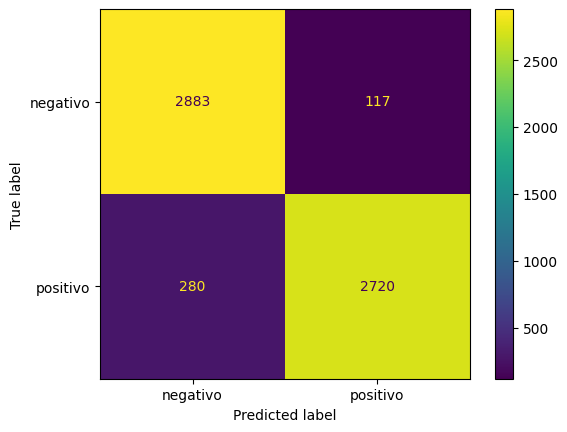

In [67]:
printModelStatistics((1,1))

Há  398  instâncias mal classificadas.
Acurácia: 0.934
F1-macro: 0.934


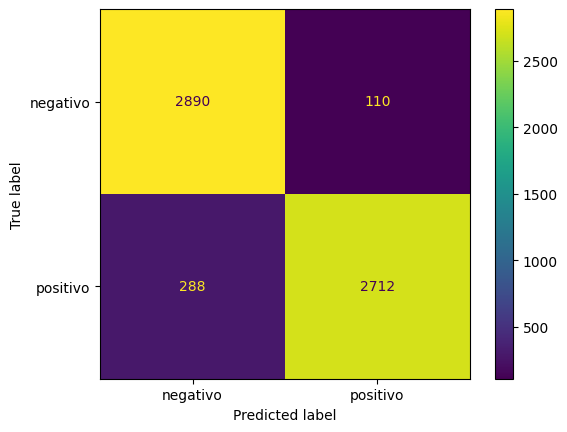

In [68]:
printModelStatistics((1,2))

Há  416  instâncias mal classificadas.
Acurácia: 0.931
F1-macro: 0.931


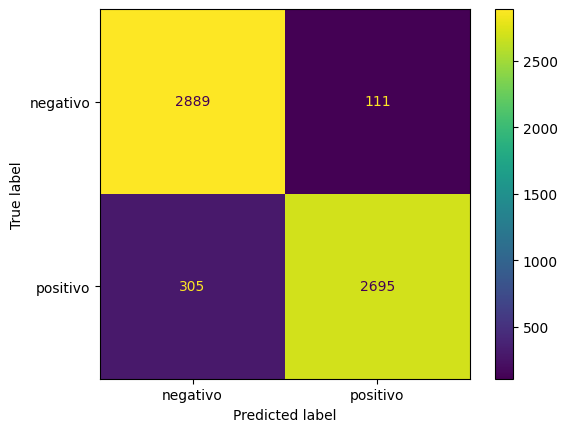

In [69]:
printModelStatistics((1,3))